<a href="https://colab.research.google.com/github/EWECORP/DScience_41870/blob/main/Desafio_CrossValidation_Eduardo_Ettlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

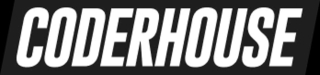

# **CURSO DE DATA SCIENCE**

# **DESAFIO  CROSS VALIDATION**

# **DESAFIO N° 15**

*AUTOR:Eduardo ETTLIN*

Entrenar uno de los modelos elegidos con las mismas variables pero aplicando alguno de los métodos aprendidos de validación cruzada

Describir si hay cambios en el performance del modelo y explicar con razones el porqué

Se recomienda utilizar entre 5-10 folds para el proceso de CrossValidation con el fin de optimizar el tiempo de ejecución de la técnica


In [1]:
#Conectamos mi drive
from google.colab import drive
#Importamos OS
import os
#Montamos drive
drive.mount('/content/gdrive', force_remount=True)
# Establecer ruta de acceso en drive
import os
print(os.getcwd())

Mounted at /content/gdrive
/content


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install featuretools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.3/618.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 7.7 MB/s eta 0:00:00


In [4]:
# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [5]:
# Me muevo a la carpeta
os.chdir("/content/gdrive/MyDrive/DScience_41870")
print(os.getcwd())

#Lectura del dataframe
datos=pd.read_csv('/content/gdrive/MyDrive/DScience_41870/US_Accidents_Dec21_updated.csv',sep=',',nrows=2845000)  # nrows: 1500000  # Disminuir Tamaño a 1.5 MM (Riginalmente Tiene 2.845.342 registros)

/content/gdrive/MyDrive/DScience_41870


In [6]:
datos.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


# REDUCCIÓN DEL DATASET - Es Muy Grande para PROCESARLO

Se utilizara la función sample para muestrear todo el DataSet.

PROBAR RANDOMIZED SEARCH
HYPER OPT
BAYES GRID SEARCH (Probabilisticos)

In [7]:
## df= datos.sample(10000)   # Achicar el Set de Datos porque no alcanza a calcular.

#df =  datos[(datos['Start_Time'] > '2020-01-01 00:00:00')]

df= datos.sample(100000)   # Achicar el Set de Datos porque no alcanza a calcular.

In [8]:
df.Severity.unique()

array([2, 3, 4, 1])

In [9]:
df.shape

(100000, 47)

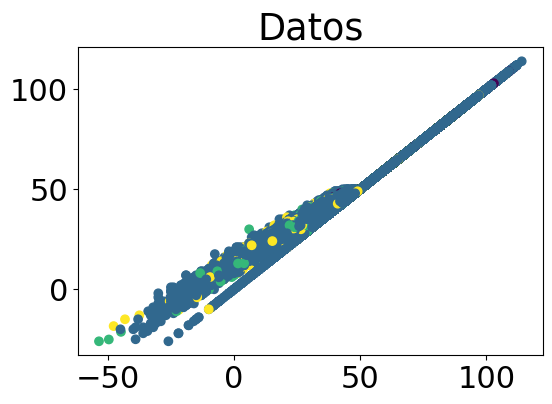

In [10]:
#Visualizacion!
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Wind_Chill(F)'], df['Temperature(F)'], c=df.Severity);
ax.set_title("Datos");

In [11]:
# Reemplazo de los vacíos
X = df.fillna(0, inplace=True)

Hola Eduardo! Cómo estás?



Te sugiero mantener simple la solución de esta entrega, por ende mejor aplicar K-fold cross validation con 5 y 10 folds. Si bien random search, grid search y otras técnicas que aplicaste también utilizan la validación cruzada, su objetivo es probar hiperparámetros. Y con Kfold testear el modelo con diferentes conjuntos de validación dentro de un mismo dataset.

Te dejo la documentación para poder aplicar cross validation: https://scikit-learn.org/stable/modules/cross_validation.html



Si surgen dudas me avisas y lo vemos!



Saludos

# Enriquecer el Modelo
Con variables derivadas de las existentes

In [12]:
df['Hora'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.hour  # Extraer la HORA del Día en la
df['Anio_Mes'] =  pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')  # Extraer AÑO y MES

df['day_of_week'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana
days = {0:'Lunes',1:'Martes',2:'Miércoeles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
df['day_of_week'] = df['day_of_week'].apply(lambda x: days[x])

df['Mes'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES


In [13]:

df['DiaS'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana

In [14]:
## Identificar la Estación Climática

def estacion_climatica(mes):
  if mes.lower() in ('january','february','march'):
    return 'Invierno'
  elif mes.lower() in ('april','may','june'):
    return 'Primavera'
  elif mes.lower() in ('july','august','september'):
    return 'Verano'
  else:
    return 'Otoño'

In [15]:
df['estacion_meteorologica'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES
df['estacion_meteorologica'] = df['estacion_meteorologica'].apply(estacion_climatica)

In [16]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Hora', 'Anio_Mes', 'day_of_week', 'Mes',
       'DiaS', 'estacion_meteorologica'],
      dtype='object')

In [78]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hora,Anio_Mes,day_of_week,Mes,DiaS,estacion_meteorologica
82157,A-82158,2,2016-06-28 16:18:01,2016-06-28 22:18:01,33.681480,-84.313130,33.686020,-84.307080,0.468,At Bouldercrest Rd/Exit 51 - Accident.,...,Day,Day,Day,Day,16,2016-06,Martes,June,1,Primavera
904898,A-904899,2,2021-12-01 16:13:00,2021-12-01 17:53:19,34.962194,-81.085464,34.962680,-81.085510,0.034,Incident on RAWLINSON RD near MABRY PKY Drive ...,...,Day,Day,Day,Day,16,2021-12,Miércoeles,December,2,Otoño
220827,A-220828,2,2017-07-26 08:15:01,2017-07-26 14:15:01,39.820980,-85.781524,39.820886,-85.787811,0.334,At 600/Exit 96 - Accident.,...,Day,Day,Day,Day,8,2017-07,Miércoeles,July,2,Verano
2284116,A-2284117,2,2020-04-29 17:33:33,2020-04-29 17:48:33,32.720760,-117.102800,32.720760,-117.102800,0.000,At CA-94/Exit 13A - Accident. Hard shoulder bl...,...,Day,Day,Day,Day,17,2020-04,Miércoeles,April,2,Primavera
2134533,A-2134534,2,2020-05-22 14:45:00,2020-05-22 17:50:02,34.106595,-117.845181,34.106595,-117.845181,0.000,At Lone Hill Ave - Accident.,...,Day,Day,Day,Day,14,2020-05,Viernes,May,4,Primavera


In [79]:
# División de los datos en train y test
X = df.drop(columns = ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State',  'Country', 'Timezone','Airport_Code', 'Weather_Timestamp',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',  'Anio_Mes', 'day_of_week', 'Mes','estacion_meteorologica', 'Hora', 'DiaS',  'Zipcode',
       'Astronomical_Twilight'], axis= 1) # Matriz de 2 columnas -Variable Independientes # 'Temperature(F)', 'Wind_Chill(F)',
y = df['Severity'] # Vector de 200 filas y 1 columna- Variable Dependiente

In [80]:
#Visualizar X
X

,Temperature(F),Wind_Chill(F)
82157,73.0,0.0
904898,65.0,65.0
220827,62.6,0.0
2284116,68.0,68.0
2134533,77.0,77.0
...,...,...
1617904,53.0,53.0
2815923,75.0,75.0
1673761,75.0,75.0
1502554,88.0,88.0


In [81]:
X.dtypes

Temperature(F)    float64
Wind_Chill(F)     float64
dtype: object

In [82]:
#Visualizar y
y

82157      2
904898     2
220827     2
2284116    2
2134533    2
          ..
1617904    2
2815923    2
1673761    2
1502554    2
1646298    2
Name: Severity, Length: 100000, dtype: int64

In [83]:
print(X.shape, y.shape)

(100000, 2) (100000,)


In [84]:
# normalizar data
#X = df_filtered.values
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [85]:
X

array([[ 0.61479862, -1.69736806],
       [ 0.23058214,  0.5146185 ],
       [ 0.1153172 , -1.69736806],
       ...,
       [ 0.71085274,  0.85492413],
       [ 1.33520451,  1.29732144],
       [-0.58587787, -0.06390106]])

# NUEVO ENFOQUE

Aprender los parámetros de una función de predicción y probarla con los mismos datos es un error metodológico: un modelo que simplemente repetiría las etiquetas de las muestras que acaba de ver tendría una puntuación perfecta pero no predeciría nada útil todavía. datos no vistos. Esta situación se llama **sobreajuste** . Para evitarlo, es una práctica común al realizar un experimento de aprendizaje automático (supervisado) mantener parte de los datos disponibles como un **conjunto de prueba** .

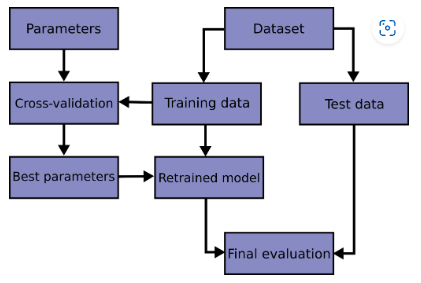

In [86]:
# Separar en train y test
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape, X_test.shape)

(60000, 2) (40000, 2)


In [89]:
y_train.shape, y_test.shape

((60000,), (40000,))

In [88]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8922

## Calcular Métricas con Validación Cruzada

In [35]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.89115, 0.89115, 0.8911 , 0.8911 , 0.8911 ])

In [36]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 accuracy with a standard deviation of 0.00


# Iteradores de Validación Cruzada

In [38]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [90]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
for X_test, y_test in kf.split(X):
      print("%s %s" % (X_train, X_test))

[[-0.24968846  0.17431288]
 [ 1.23915039  1.22926032]
 [ 1.09506921  1.12716863]
 ...
 [-0.00955316  0.34446569]
 [-0.58587787 -0.16599275]
 [-0.29771552  0.14028232]] [50000 50001 50002 ... 99997 99998 99999]
[[-0.24968846  0.17431288]
 [ 1.23915039  1.22926032]
 [ 1.09506921  1.12716863]
 ...
 [-0.00955316  0.34446569]
 [-0.58587787 -0.16599275]
 [-0.29771552  0.14028232]] [    0     1     2 ... 49997 49998 49999]


In [91]:
X_train.shape

(60000, 2)

In [92]:
y_train.shape

(60000,)

In [95]:
# Generate uneven groups
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(60000, group_prior))

<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

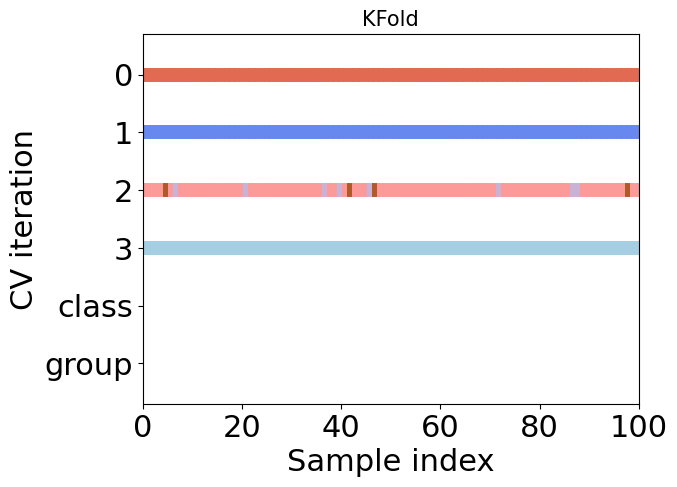

In [96]:
fig, ax = plt.subplots()
plot_cv_indices(kf, X_train, y_train, groups, ax, n_splits)

# Repeated K-Fold

In [97]:
from sklearn.model_selection import RepeatedKFold
#X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in rkf.split(X):
      print("%s %s" % (X_train, y_train))

[[-0.24968846  0.17431288]
 [ 1.23915039  1.22926032]
 [ 1.09506921  1.12716863]
 ...
 [-0.00955316  0.34446569]
 [-0.58587787 -0.16599275]
 [-0.29771552  0.14028232]] 1099101    2
609081     2
2086594    2
1532989    2
2480401    2
          ..
1434142    2
2718066    2
1784832    2
1847814    2
2164329    2
Name: Severity, Length: 60000, dtype: int64
[[-0.24968846  0.17431288]
 [ 1.23915039  1.22926032]
 [ 1.09506921  1.12716863]
 ...
 [-0.00955316  0.34446569]
 [-0.58587787 -0.16599275]
 [-0.29771552  0.14028232]] 1099101    2
609081     2
2086594    2
1532989    2
2480401    2
          ..
1434142    2
2718066    2
1784832    2
1847814    2
2164329    2
Name: Severity, Length: 60000, dtype: int64
[[-0.24968846  0.17431288]
 [ 1.23915039  1.22926032]
 [ 1.09506921  1.12716863]
 ...
 [-0.00955316  0.34446569]
 [-0.58587787 -0.16599275]
 [-0.29771552  0.14028232]] 1099101    2
609081     2
2086594    2
1532989    2
2480401    2
          ..
1434142    2
2718066    2
1784832    2
18478

<Axes: title={'center': 'RepeatedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

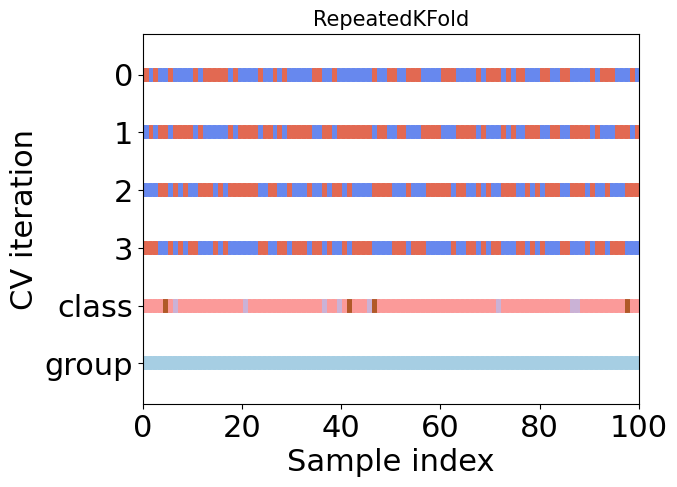

In [102]:
fig, ax = plt.subplots()

plot_cv_indices(rkf, X_train, y_train, groups, ax, n_splits)

Permutaciones Random


In [100]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for train_index, test_index in ss.split(X):
   print("%s %s" % (train_index, test_index))

[ 2606 57228  8382 ... 42613 43567 68268] [ 3582 60498 53227 ... 87585 32519 18831]
[54135 13917 25607 ... 84389 26023  1298] [10655 29762 63784 ... 52099 83917 94421]
[13986 72264 36901 ... 10928 25125 32837] [16037 17477 92520 ... 90396 43393 22859]
[ 3640 67692 21713 ...  5533 53060 59475] [26719 56479 99173 ...  7489  9891 74791]
[75543  6113  5711 ... 69700 71225 77942] [21212 90847 98957 ... 66361 70487 33464]


<Axes: title={'center': 'ShuffleSplit'}, xlabel='Sample index', ylabel='CV iteration'>

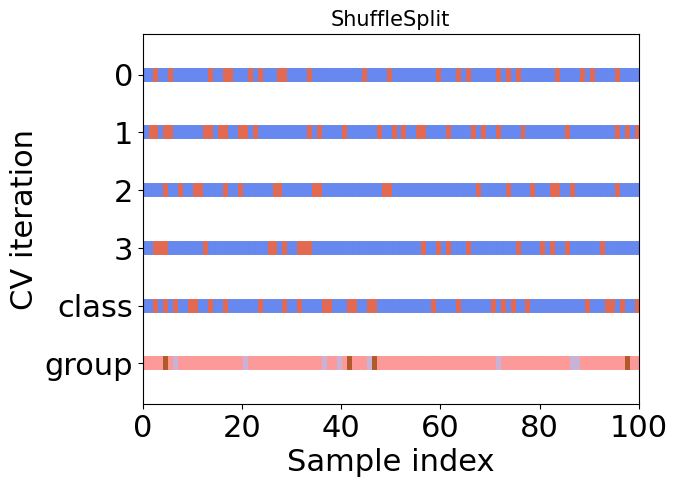

In [101]:
fig, ax = plt.subplots()
plot_cv_indices(ss, X_train, y_train, groups, ax, n_splits)